In [1]:
import numpy as np
import pandas as pd
import random
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())


Saving concatenated_202210.csv_changing_columns.csv to concatenated_202210.csv_changing_columns.csv


In [2]:
features = data
target = data['FH.6000.[ENS] - Energy Signals.Momentary power consumption']

numeric_features = features.select_dtypes(include=[np.number])

weighted_features = numeric_features.copy()


for column in weighted_features.columns:
    if column != 'FH.6000.[ENS] - Energy Signals.Momentary power consumption':
        correlation, _ = pearsonr(weighted_features[column], target)
        weighted_features[column] *= correlation

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(weighted_features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))


scaled_features_df = pd.DataFrame(scaled_features, index=weighted_features.index, columns=weighted_features.columns)


scaled_features_df.head()

,timestamp,FH.6000.[ENS] - Energy Signals.Momentary current consuption,FH.6000.[ENS] - Energy Signals.Battery cell voltage,FH.6000.[ENS] - Energy Signals.Momentary power consumption,FH.6000.[ENS] - Energy Signals.Momentary energy consumption,FH.6000.[ENS] - Energy Signals.Cumulative energy consumption,FH.6000.[ENS] - Energy Signals.SOC - State Of Charge,FH.6000.[G1LDS] GROUP 1 - LEFT DRIVE SIGNALS.ActualSpeed_L,FH.6000.[G2RDS] GROUP 2 - RIGHT DRIVE SIGNALS.ActualSpeed_R,FH.6000.[LED] LED STATUS.LED status - active mode,...,FH.6000.[NNS] - Natural Navigation Signals.Speed,FH.6000.[NNS] - Natural Navigation Signals.Going to ID,FH.6000.[NNS] - Natural Navigation Signals.Target reached,FH.6000.[NNS] - Natural Navigation Signals.Current segment,FH.6000.[ODS] - Odometry Signals.Momentary frequency of left encoder pulses,FH.6000.[ODS] - Odometry Signals.Momentary frequency of right encoder pulses,FH.6000.[ODS] - Odometry Signals.Cumulative distance left,FH.6000.[ODS] - Odometry Signals.Cumulative distance right,FH.6000.[SS] SAFETY SIGNALS.Scanners active zones,payload_weight
0,0.996667,0.644317,0.728013,0.656075,0.754139,0.276506,0.615385,0.273423,0.921635,0.980469,...,0.202740,0.0,1.0,0.949153,0.023241,0.846213,0.181151,0.176630,1.0,1.0
1,1.000000,0.457073,0.675896,0.467290,0.687922,0.196988,0.576923,0.954111,0.080068,0.996094,...,0.925138,1.0,1.0,0.457627,0.645903,0.776445,0.095710,0.091033,1.0,1.0
2,1.000000,0.457073,0.675896,0.467290,0.687922,0.196988,0.576923,0.954111,0.080068,0.996094,...,0.925138,1.0,1.0,0.457627,0.645903,0.776445,0.095710,0.091033,1.0,1.0
3,0.999998,0.457073,0.675896,0.467290,0.687922,0.196988,0.576923,0.957935,0.073254,0.996094,...,0.947726,1.0,1.0,0.457627,0.404181,0.532290,0.095710,0.091033,1.0,1.0
4,0.999995,0.457073,0.675896,0.467290,0.687922,0.196988,0.576923,0.950287,0.109029,0.996094,...,0.957667,1.0,1.0,0.457627,0.161087,0.288653,0.095710,0.091372,1.0,1.0


In [3]:
def create_sequences(features, target, sequence_length):
    xs, ys = [], []
    for i in range(len(features) - sequence_length):
        x = features[i:i + sequence_length]
        y = target[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
sequence_length = 50


X, y = create_sequences(scaled_features, scaled_target, sequence_length)

print(f'Input shape (X): {X.shape}')
print(f'Target shape (y): {y.shape}')


Input shape (X): (49592, 50, 31)
Target shape (y): (49592, 1)


In [4]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.05, shuffle=False)

In [5]:

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 128)             │          81,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,621 (678.21 KB)

 Trainable params: 173,621 (678.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 119s 212ms/step - loss: 0.0139 - val_loss: 0.0013
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 139s 206ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 112s 207ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 147s 217ms/step - loss: 0.0025 - val_loss: 8.0791e-04
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 112s 206ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 144s 211ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 141s 209ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 142s 209ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 143s 211ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 112s 206ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 144s 210ms/step - loss: 0.0020 - val_loss: 0.0015
Epoc

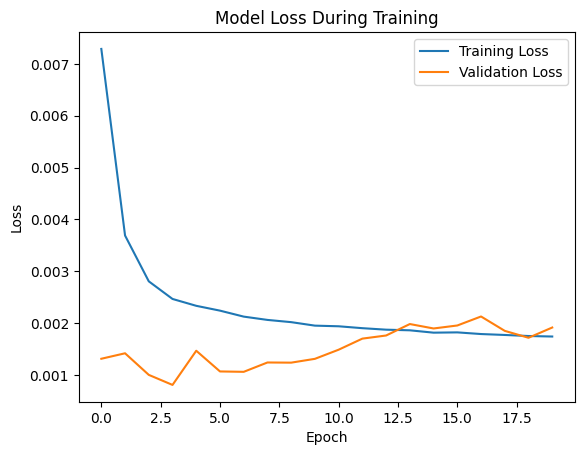

In [6]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val))


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Mean Squared Error: 0.0008358261678701322
Mean Absolute Error (MAE): 0.016634860423251026
Root Mean Squared Error (RMSE): 0.028910658378358184


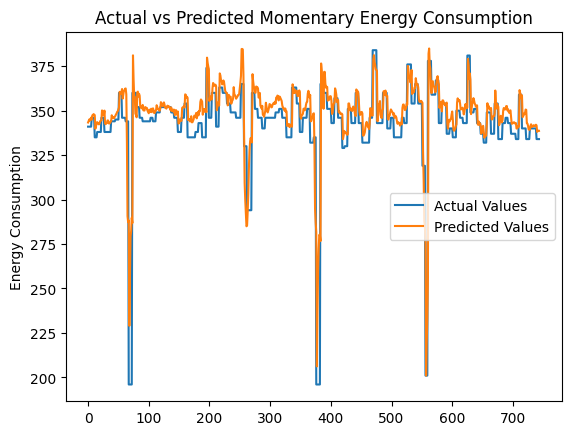

In [7]:

y_pred = model.predict(X_test)

y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = target_scaler.inverse_transform(y_pred)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

plt.plot(y_test_rescaled, label='Actual Values')
plt.plot(y_pred_rescaled, label='Predicted Values')
plt.title('Actual vs Predicted Momentary Energy Consumption')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()